# ITI110 Model Optimsation with Optuna - hourly / loss: Poisson (N-BEATS) (Mag)
#### Loss function: Poisson

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch

# Test on hourly dataset

### Load data and extract columns required for training

In [3]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

user_folder = '/content/drive/My Drive/Data/ITI110/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv(user_folder + '2.2 merged_aggregated_hourly_without_block_id.csv')
df['ds'] = pd.to_datetime(df["tstp"], format='%Y-%m-%d %H:%M:%S')
# Extract columns required for training and convert column names to NBEATS config
df_nbeats = df[['ds', 'avg_energy_per_lclid', 'holiday', 'temperature', 'humidity', 'windSpeed']]
df_nbeats.insert(1, 'unique_id', 1)
df_nbeats['unique_id'] = 1
df_nbeats.rename(columns={'avg_energy_per_lclid':'y'}, inplace= True)
df_nbeats.head()


,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [ ]:
df_nbeats.dtypes

ds             datetime64[ns]
unique_id               int64
y                     float64
holiday               float64
temperature           float64
humidity              float64
windSpeed             float64
dtype: object

In [5]:
df_nbeats['y'] = df_nbeats['y'].astype('float')
df_nbeats['holiday'] = df_nbeats['holiday'].astype('float')
df_nbeats['temperature'] = df_nbeats['temperature'].astype('float')
df_nbeats['humidity'] = df_nbeats['humidity'].astype('float')
df_nbeats['windSpeed'] = df_nbeats['windSpeed'].astype('float')


In [ ]:
# # Extract columns required for training and convert column names to NBEATS config
# df_nbeats = df[['ds', 'avg_energy_per_lclid', 'holiday', 'temperature', 'humidity', 'windSpeed']]
# df_nbeats.insert(1, 'unique_id', 1)
# df_nbeats['unique_id'] = 1
# df_nbeats.rename(columns={'avg_energy_per_lclid':'y'}, inplace= True)
# df_nbeats.head()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


### Check on missing data and compare different methods of imputation

In [ ]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
15758,2013-09-09 23:00:00,1,0.294621,0.0,NaN,NaN,NaN
15759,2013-09-10 00:00:00,1,0.251980,0.0,NaN,NaN,NaN


In [6]:
# Apply interpolation on dataset
df_nbeats = df_nbeats.interpolate("ffill")
df_nbeats.isna().any()

ds             False
unique_id      False
y              False
holiday        False
temperature    False
humidity       False
windSpeed      False
dtype: bool

In [ ]:
df_nbeats[df_nbeats.isna().any(axis=1)]

,ds,unique_id,y,holiday,temperature,humidity,windSpeed


### Split data into train and test datasets

In [ ]:
# reserve 7 days *24 hours data for test
# test = 168 data points

In [7]:
# Test_value: 0.8

test = df_nbeats[len(df_nbeats) - 168:]  # start row: 19696

train_rows = int(0.8*(len(df_nbeats)-168))

train = df_nbeats[:train_rows]
val = df_nbeats[train_rows:-168]

# Check rows
print("dataset size: ", len(df_nbeats))
print("train length: ", len(train))
print("last row of train: ", train.index[-1])
print("val length: ", len(val))
print("first row of val: ", val.index[0])
print("last row of val: ", val.index[-1])
print("test length: ", len(test))
print("first row of test: ", test.index[0])
print("last row of test: ", test.index[-1])

dataset size:  19864
train length:  15756
last row of train:  15755
val length:  3940
first row of val:  15756
last row of val:  19695
test length:  168
first row of test:  19696
last row of test:  19863


In [ ]:
train.head()

,ds,unique_id,y,holiday,temperature,humidity,windSpeed
0,2011-11-23 09:00:00,1,0.565000,0.0,4.84,0.99,1.78
1,2011-11-23 10:00:00,1,0.251333,0.0,5.74,0.98,1.99
2,2011-11-23 11:00:00,1,0.303286,0.0,7.67,0.88,2.66
3,2011-11-23 12:00:00,1,0.658900,0.0,8.84,0.85,2.80
4,2011-11-23 13:00:00,1,0.481769,0.0,9.87,0.82,3.12


In [8]:
!pip install optuna

In [9]:
!pip install neuralforecast

In [10]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import DistributionLoss, MAE, MAPE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import optuna


### Optuna tuning with temperature (MAE: 0.0654)

In [11]:
# Create function for Optuna tuning

h = val['ds'].nunique()

def objective(trial):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128, 256, 512])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATS(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 futr_exog_list=['temperature'],
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='H')
    model.fit(train)

    p = model.predict(futr_df=val).reset_index()
    p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['NBEATS'])
    rmse = mean_squared_error(p['y'], p['NBEATS'], squared=False)
    mape = mean_absolute_percentage_error(p['y'], p['NBEATS'])

    input_size_value.append(input_size)
    n_blocks_season_value.append(n_blocks_season)
    n_blocks_trend_value.append(n_blocks_trend)
    n_blocks_identity_value.append(n_blocks_identity)
    mlp_units_value.append(mlp_units_n)
    num_hidden_value.append(num_hidden)
    n_harmonics_value.append(n_harmonics)
    n_polynomials_value.append(n_polynomials)
    scaler_type_value.append(scaler_type)
    learning_rate_value.append(learning_rate)
    MAE_value.append(loss)
    RMSE_value.append(rmse)
    MAPE_value.append(mape)
    Loss_Fn.append("Poisson")

    return loss

input_size_value = []
n_blocks_season_value = []
n_blocks_trend_value = []
n_blocks_identity_value = []
mlp_units_value = []
num_hidden_value = []
n_harmonics_value = []
n_polynomials_value = []
scaler_type_value = []
learning_rate_value = []
MAE_value = []
RMSE_value = []
MAPE_value = []
Loss_Fn = []

In [12]:
eval = optuna.create_study(direction='minimize')
eval.optimize(objective, n_trials=30)

[I 2024-02-24 17:30:25,449] A new study created in memory with name: no-name-dd631465-b303-45f1-a3c9-95c0f4afe156
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:31:26,881] Trial 0 finished with value: 0.4501815535515491 and parameters: {'input_size': 19, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 256, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.06387804092729463}. Best is trial 0 with value: 0.4501815535515491.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:31:55,642] Trial 1 finished with value: 0.23962078907233558 and parameters: {'input_size': 21, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 8.531531975928653e-05}. Best is trial 1 with value: 0.23962078907233558.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:32:04,617] Trial 2 finished with value: 0.11392706658575573 and parameters: {'input_size': 27, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0001843289031639419}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:32:31,507] Trial 3 finished with value: 0.31453865112388507 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 4.5230370901348736e-05}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:33:14,752] Trial 4 finished with value: 0.4501815535515491 and parameters: {'input_size': 5, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.009372682094154724}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:33:23,391] Trial 5 finished with value: 0.5352879322992097 and parameters: {'input_size': 3, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 4.786711730242373e-05}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:33:45,301] Trial 6 finished with value: 0.14652773304708713 and parameters: {'input_size': 34, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 7.471701091124486e-05}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:34:00,178] Trial 7 finished with value: 0.1572793766927222 and parameters: {'input_size': 19, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.002518940205730311}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:34:17,368] Trial 8 finished with value: 0.16165647629693763 and parameters: {'input_size': 56, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.00047153064605324525}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:34:30,989] Trial 9 finished with value: 0.13582108710312585 and parameters: {'input_size': 32, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.00022022717187300902}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:34:43,093] Trial 10 finished with value: 0.2900921230365556 and parameters: {'input_size': 45, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 1.0928282703403843e-05}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:34:54,384] Trial 11 finished with value: 0.12983882178146391 and parameters: {'input_size': 33, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0005146363448716032}. Best is trial 2 with value: 0.11392706658575573.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:35:08,117] Trial 12 finished with value: 0.06545280605720555 and parameters: {'input_size': 41, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0019886613692826844}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:35:18,396] Trial 13 finished with value: 0.08752023642743674 and parameters: {'input_size': 45, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.0034016768031434005}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:35:39,865] Trial 14 finished with value: 0.4501815535515491 and parameters: {'input_size': 46, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0027078332453677073}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:35:50,194] Trial 15 finished with value: 0.4501815535515491 and parameters: {'input_size': 45, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.010437270010563084}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:36:03,872] Trial 16 finished with value: 0.4501815535515491 and parameters: {'input_size': 52, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.01880904450915814}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:36:20,335] Trial 17 finished with value: 0.4501815535515491 and parameters: {'input_size': 38, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0029622048315318906}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:36:36,017] Trial 18 finished with value: 0.09002009322347222 and parameters: {'input_size': 41, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0014748500924161173}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:37:03,171] Trial 19 finished with value: 0.4501815535515491 and parameters: {'input_size': 52, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.06585076817421867}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:37:23,871] Trial 20 finished with value: 0.4501815535515491 and parameters: {'input_size': 27, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.00631179576621773}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:37:39,714] Trial 21 finished with value: 0.08528650036815594 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.001155091696690788}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:37:58,154] Trial 22 finished with value: 0.08916196699871014 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0008792587307736853}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:38:13,181] Trial 23 finished with value: 0.4501815535515491 and parameters: {'input_size': 50, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.02155663344996238}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:38:26,214] Trial 24 finished with value: 0.07370120629975835 and parameters: {'input_size': 41, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.001152607628129417}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:38:39,244] Trial 25 finished with value: 0.0792391486624937 and parameters: {'input_size': 37, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0007514015454852583}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:38:52,285] Trial 26 finished with value: 0.10514402210720679 and parameters: {'input_size': 27, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.0003925541191398757}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:39:05,292] Trial 27 finished with value: 0.12135667408585823 and parameters: {'input_size': 12, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0008963030491076972}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:39:24,392] Trial 28 finished with value: 0.16932226824232674 and parameters: {'input_size': 36, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.00023141320429125706}. Best is trial 12 with value: 0.06545280605720555.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:39:48,121] Trial 29 finished with value: 0.4501815535515491 and parameters: {'input_size': 42, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0322727234153228}. Best is trial 12 with value: 0.06545280605720555.


In [13]:
eval.best_params

{'input_size': 41,
 'n_blocks_season': 1,
 'n_blocks_trend': 1,
 'n_blocks_ident': 2,
 'mlp_units': 512,
 'num_hidden': 2,
 'n_harmonics': 2,
 'n_polynomials': 3,
 'scaler_type': 'standard',
 'learning_rate': 0.0019886613692826844}

In [14]:
eval.best_value

0.06545280605720555

In [15]:
dict_results_poisson = {'input_size': input_size_value, 'n_blocks_season': n_blocks_season_value, 'n_blocks_trend': n_blocks_trend_value, \
                    'n_blocks_identity': n_blocks_identity_value, 'mlp_units': mlp_units_value, 'num_hidden': num_hidden_value,  \
                    'n_harmonics': n_harmonics_value, 'n_polynomials': n_polynomials_value, 'scaler_type': scaler_type_value,  \
                    'learning_rate': learning_rate_value, 'MAE': MAE_value, 'RMSE': RMSE_value, 'MAPE': MAPE_value, 'Loss Fn': Loss_Fn}

df_results_poisson = pd.DataFrame(dict_results_poisson)
df_results_poisson

,input_size,n_blocks_season,n_blocks_trend,n_blocks_identity,mlp_units,num_hidden,n_harmonics,n_polynomials,scaler_type,learning_rate,MAE,RMSE,MAPE,Loss Fn
0,19,3,1,1,256,3,4,2,standard,0.063878,0.450182,0.476066,1.000000,Poisson
1,21,2,2,1,64,3,4,4,standard,0.000085,0.239621,0.310644,0.623549,Poisson
2,27,1,1,1,256,2,1,2,standard,0.000184,0.113927,0.140392,0.284622,Poisson
3,60,2,3,3,256,1,3,1,robust,0.000045,0.314539,0.430648,0.800394,Poisson
4,5,2,3,3,512,2,5,4,robust,0.009373,0.450182,0.476066,1.000000,Poisson
5,3,1,2,1,32,2,1,5,standard,0.000048,0.535288,0.563734,1.496266,Poisson
6,34,1,1,1,128,3,5,5,robust,0.000075,0.146528,0.179028,0.401993,Poisson
7,19,3,3,1,32,1,1,2,robust,0.002519,0.157279,0.192995,0.429878,Poisson
8,56,2,2,1,64,1,2,1,standard,0.000472,0.161656,0.200761,0.436720,Poisson
9,32,1,1,2,64,3,3,5,standard,0.000220,0.135821,0.166716,0.360251,Poisson


In [16]:
df_results_poisson.to_csv(user_folder + "hourly_results_NBEATS_Optuna_Poisson_with temp.csv", index = False)

In [17]:
# Check best param plot

input_size = 41

n_blocks_season = 1
n_blocks_trend = 1
n_blocks_identity = 2

mlp_units_n = 512
num_hidden = 2

n_harmonics = 2
n_polynomials = 3

scaler_type = 'standard'
learning_rate = 0.0019886613692826844


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATS(h=h,input_size=input_size,
              loss=DistributionLoss(distribution='Poisson', level=[90]),
              futr_exog_list=['temperature'],
              max_steps=100,
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
          ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p = model.predict(futr_df=val).reset_index()
p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss = mean_absolute_error(p['y'], p['NBEATS'])



INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
print(loss)
p

0.06545280605720555


,unique_id,ds,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,1,2013-09-09 21:00:00,0.573,0.0,0.0,2.0,0.518124
1,1,2013-09-09 22:00:00,0.529,0.0,0.0,2.0,0.404168
2,1,2013-09-09 23:00:00,0.392,0.0,0.0,2.0,0.294621
3,1,2013-09-10 00:00:00,0.315,0.0,0.0,1.0,0.251980
4,1,2013-09-10 01:00:00,0.278,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...
3935,1,2014-02-20 20:00:00,0.605,0.0,0.0,2.0,0.676087
3936,1,2014-02-20 21:00:00,0.576,0.0,0.0,2.0,0.638370
3937,1,2014-02-20 22:00:00,0.482,0.0,0.0,2.0,0.574031
3938,1,2014-02-20 23:00:00,0.434,0.0,0.0,2.0,0.470768


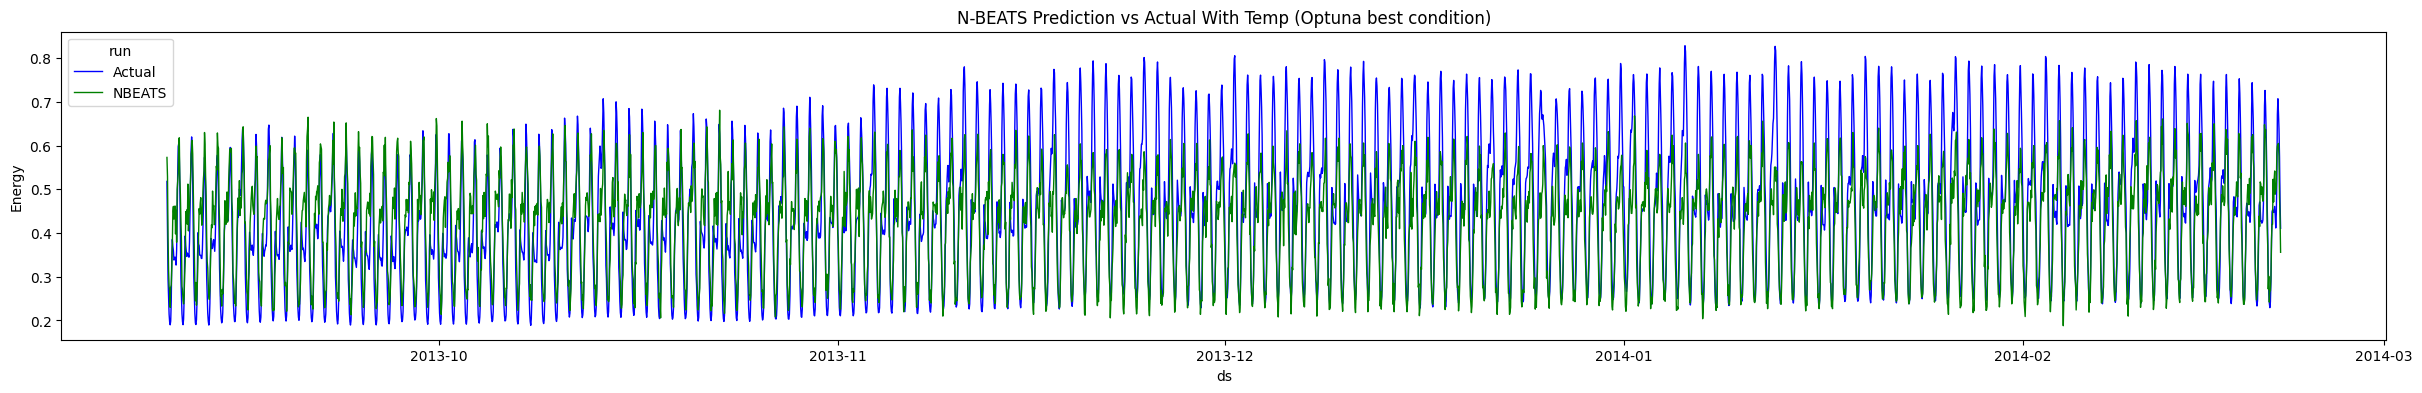

MAE:  0.06545280605720555


In [21]:
df_pred_melt = pd.melt(p, id_vars=['ds'], value_vars=['y', 'NBEATS'], var_name='run', value_name='Energy')
df_pred_melt.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATS Prediction vs Actual With Temp (Optuna best condition)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()

print('MAE: ',loss)


In [22]:
# combine prediction results with weather parameters
df_pred_combined = val[['ds','temperature']].merge(p, on = 'ds', how = 'left')
df_pred_combined

,ds,temperature,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,2013-09-09 21:00:00,10.33,1,0.573,0.0,0.0,2.0,0.518124
1,2013-09-09 22:00:00,10.33,1,0.529,0.0,0.0,2.0,0.404168
2,2013-09-09 23:00:00,10.33,1,0.392,0.0,0.0,2.0,0.294621
3,2013-09-10 00:00:00,10.33,1,0.315,0.0,0.0,1.0,0.251980
4,2013-09-10 01:00:00,10.36,1,0.278,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...,...
3935,2014-02-20 20:00:00,7.34,1,0.605,0.0,0.0,2.0,0.676087
3936,2014-02-20 21:00:00,6.84,1,0.576,0.0,0.0,2.0,0.638370
3937,2014-02-20 22:00:00,6.86,1,0.482,0.0,0.0,2.0,0.574031
3938,2014-02-20 23:00:00,6.34,1,0.434,0.0,0.0,2.0,0.470768


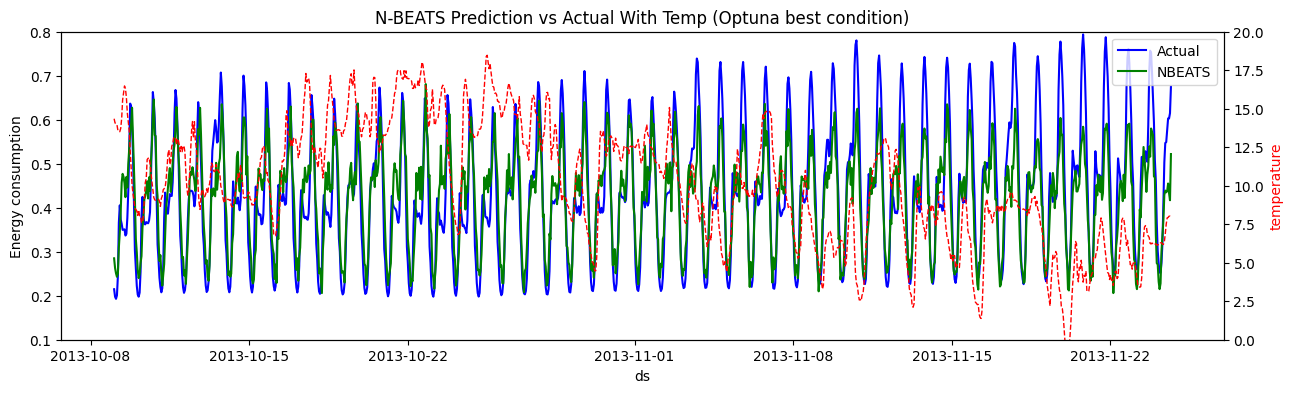

In [25]:
df_pred_nov = df_pred_combined[-3240:-2120].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

### Optuna tuning without temperature (MAE = 0.0693)

In [11]:
# Create function for Optuna tuning

h = val['ds'].nunique()

def objective(trial):

    input_size = trial.suggest_int('input_size', 1, 60)

    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)

    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128, 256, 512])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)

    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)

    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)


    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATS(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='H')
    model.fit(train)

    p = model.predict(futr_df=val).reset_index()
    p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['NBEATS'])
    rmse = mean_squared_error(p['y'], p['NBEATS'], squared=False)
    mape = mean_absolute_percentage_error(p['y'], p['NBEATS'])

    input_size_value.append(input_size)
    n_blocks_season_value.append(n_blocks_season)
    n_blocks_trend_value.append(n_blocks_trend)
    n_blocks_identity_value.append(n_blocks_identity)
    mlp_units_value.append(mlp_units_n)
    num_hidden_value.append(num_hidden)
    n_harmonics_value.append(n_harmonics)
    n_polynomials_value.append(n_polynomials)
    scaler_type_value.append(scaler_type)
    learning_rate_value.append(learning_rate)
    MAE_value.append(loss)
    RMSE_value.append(rmse)
    MAPE_value.append(mape)
    Loss_Fn.append("Poisson")

    return loss

input_size_value = []
n_blocks_season_value = []
n_blocks_trend_value = []
n_blocks_identity_value = []
mlp_units_value = []
num_hidden_value = []
n_harmonics_value = []
n_polynomials_value = []
scaler_type_value = []
learning_rate_value = []
MAE_value = []
RMSE_value = []
MAPE_value = []
Loss_Fn = []

In [12]:
eval = optuna.create_study(direction='minimize')
eval.optimize(objective, n_trials=30)

[I 2024-02-24 17:58:57,412] A new study created in memory with name: no-name-a98663b0-06f3-480b-8580-26f60a19929a
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:59:21,704] Trial 0 finished with value: 0.24943565171820561 and parameters: {'input_size': 54, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.00016178329199278876}. Best is trial 0 with value: 0.24943565171820561.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 17:59:45,029] Trial 1 finished with value: 0.17240986192186494 and parameters: {'input_size': 24, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.0001887235000031691}. Best is trial 1 with value: 0.17240986192186494.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:00:06,349] Trial 2 finished with value: 0.13505257022645759 and parameters: {'input_size': 51, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 5.4434206481568755e-05}. Best is trial 2 with value: 0.13505257022645759.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:01:04,880] Trial 3 finished with value: 0.4501815535515491 and parameters: {'input_size': 21, 'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 0.010792127765123337}. Best is trial 2 with value: 0.13505257022645759.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:01:25,139] Trial 4 finished with value: 0.10297900240974416 and parameters: {'input_size': 36, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.0028446766278817375}. Best is trial 4 with value: 0.10297900240974416.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:01:41,369] Trial 5 finished with value: 0.4501815535515491 and parameters: {'input_size': 19, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.01673298990074759}. Best is trial 4 with value: 0.10297900240974416.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:01:55,472] Trial 6 finished with value: 0.4501815535515491 and parameters: {'input_size': 49, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 256, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.06557774212834504}. Best is trial 4 with value: 0.10297900240974416.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:02:04,203] Trial 7 finished with value: 0.09208265591299024 and parameters: {'input_size': 27, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'standard', 'learning_rate': 0.000353670829471434}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:02:21,544] Trial 8 finished with value: 0.10377523661239636 and parameters: {'input_size': 24, 'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 0.010488933257362505}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:02:50,067] Trial 9 finished with value: 1.2237477449362593 and parameters: {'input_size': 52, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 4, 'scaler_type': 'standard', 'learning_rate': 1.4563101522817132e-05}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:03:02,040] Trial 10 finished with value: 0.12592151985838432 and parameters: {'input_size': 5, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0009204385543307271}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:03:22,112] Trial 11 finished with value: 0.09557801166938898 and parameters: {'input_size': 38, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0016770523144681465}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:03:34,207] Trial 12 finished with value: 0.13584607386967756 and parameters: {'input_size': 39, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.0004309912382681356}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:03:57,745] Trial 13 finished with value: 0.4501815535515491 and parameters: {'input_size': 39, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0019865310705379368}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:04:22,779] Trial 14 finished with value: 0.13644370453200097 and parameters: {'input_size': 10, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 6.588403979986174e-05}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:04:32,050] Trial 15 finished with value: 0.09402411786382288 and parameters: {'input_size': 31, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.003389881467108892}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:04:40,536] Trial 16 finished with value: 0.11139544881566325 and parameters: {'input_size': 31, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 0.005326693459130575}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:04:55,082] Trial 17 finished with value: 0.15582670062246928 and parameters: {'input_size': 15, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0005320383106008548}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:05:06,113] Trial 18 finished with value: 0.4501815535515491 and parameters: {'input_size': 29, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.04975460498497149}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:05:19,188] Trial 19 finished with value: 0.2022128069302866 and parameters: {'input_size': 60, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 256, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 1.3173257862363087e-05}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:05:41,183] Trial 20 finished with value: 0.11365282578058376 and parameters: {'input_size': 45, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 512, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0001953824006484391}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:06:01,445] Trial 21 finished with value: 0.12584539724018945 and parameters: {'input_size': 33, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.001677880941149294}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:06:18,686] Trial 22 finished with value: 0.1015322019376569 and parameters: {'input_size': 43, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.003314515857839151}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:06:27,936] Trial 23 finished with value: 0.12976573207288303 and parameters: {'input_size': 28, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.0007861120304196488}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:06:42,077] Trial 24 finished with value: 0.12146847078886361 and parameters: {'input_size': 37, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 1, 'scaler_type': 'robust', 'learning_rate': 0.00561184953811264}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:06:54,479] Trial 25 finished with value: 0.09377503571486644 and parameters: {'input_size': 27, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.000368698188218165}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:07:06,588] Trial 26 finished with value: 0.1156701846340456 and parameters: {'input_size': 13, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 0.00040211086725868306}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:07:18,983] Trial 27 finished with value: 0.14333773486289406 and parameters: {'input_size': 25, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'robust', 'learning_rate': 9.466658302594022e-05}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:07:30,820] Trial 28 finished with value: 0.4501815535515491 and parameters: {'input_size': 18, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.027068911243646722}. Best is trial 7 with value: 0.09208265591299024.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2024-02-24 18:07:39,708] Trial 29 finished with value: 0.2989697630805805 and parameters: {'input_size': 32, 'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 2.7445633821037256e-05}. Best is trial 7 with value: 0.09208265591299024.


In [13]:
eval.best_params

{'input_size': 27,
 'n_blocks_season': 1,
 'n_blocks_trend': 2,
 'n_blocks_ident': 3,
 'mlp_units': 128,
 'num_hidden': 1,
 'n_harmonics': 1,
 'n_polynomials': 1,
 'scaler_type': 'standard',
 'learning_rate': 0.000353670829471434}

In [14]:
eval.best_value

0.09208265591299024

In [15]:
dict_results_poisson = {'input_size': input_size_value, 'n_blocks_season': n_blocks_season_value, 'n_blocks_trend': n_blocks_trend_value, \
                    'n_blocks_identity': n_blocks_identity_value, 'mlp_units': mlp_units_value, 'num_hidden': num_hidden_value,  \
                    'n_harmonics': n_harmonics_value, 'n_polynomials': n_polynomials_value, 'scaler_type': scaler_type_value,  \
                    'learning_rate': learning_rate_value, 'MAE': MAE_value, 'RMSE': RMSE_value, 'MAPE': MAPE_value, 'Loss Fn': Loss_Fn}

df_results_poisson = pd.DataFrame(dict_results_poisson)
df_results_poisson

,input_size,n_blocks_season,n_blocks_trend,n_blocks_identity,mlp_units,num_hidden,n_harmonics,n_polynomials,scaler_type,learning_rate,MAE,RMSE,MAPE,Loss Fn
0,54,1,1,2,32,3,1,5,standard,0.000162,0.249436,0.318681,0.682207,Poisson
1,24,3,3,1,64,2,2,3,robust,0.000189,0.172410,0.216896,0.457723,Poisson
2,51,2,1,2,512,2,2,4,standard,0.000054,0.135053,0.166558,0.341843,Poisson
3,21,3,1,2,512,2,5,4,standard,0.010792,0.450182,0.476066,1.000000,Poisson
4,36,1,1,1,32,2,5,4,robust,0.002845,0.102979,0.130209,0.222507,Poisson
5,19,1,3,1,64,1,4,5,standard,0.016733,0.450182,0.476066,1.000000,Poisson
6,49,1,2,1,256,1,3,5,standard,0.065578,0.450182,0.476066,1.000000,Poisson
7,27,1,2,3,128,1,1,1,standard,0.000354,0.092083,0.113987,0.224696,Poisson
8,24,1,1,3,64,1,4,5,robust,0.010489,0.103775,0.126979,0.290449,Poisson
9,52,2,1,1,128,1,4,4,standard,0.000015,1.223748,2.228835,3.081886,Poisson


In [16]:
df_results_poisson.to_csv(user_folder + "hourly_results_NBEATS_Optuna_Poisson_without temp.csv", index = False)

In [18]:
input_size = 48

n_blocks_season = 1
n_blocks_trend = 3
n_blocks_identity = 2

mlp_units_n = 32
num_hidden = 3

n_harmonics = 2
n_polynomials = 4

scaler_type = 'robust'
learning_rate = 0.0074547496109055545


n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
models = [NBEATS(h=h,input_size=input_size,
              loss=DistributionLoss(distribution='Poisson', level=[90]),
              max_steps=100,
              stack_types=['seasonality', 'trend', 'identity'],
              mlp_units=mlp_units,
              n_blocks=n_blocks,
              learning_rate=learning_rate,
              n_harmonics=n_harmonics,
              n_polynomials=n_polynomials,
              scaler_type=scaler_type)
          ]
model = NeuralForecast(models=models, freq='H')
model.fit(train)

p = model.predict(futr_df=val).reset_index()
p = p.merge(val[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

loss = mean_absolute_error(p['y'], p['NBEATS'])

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

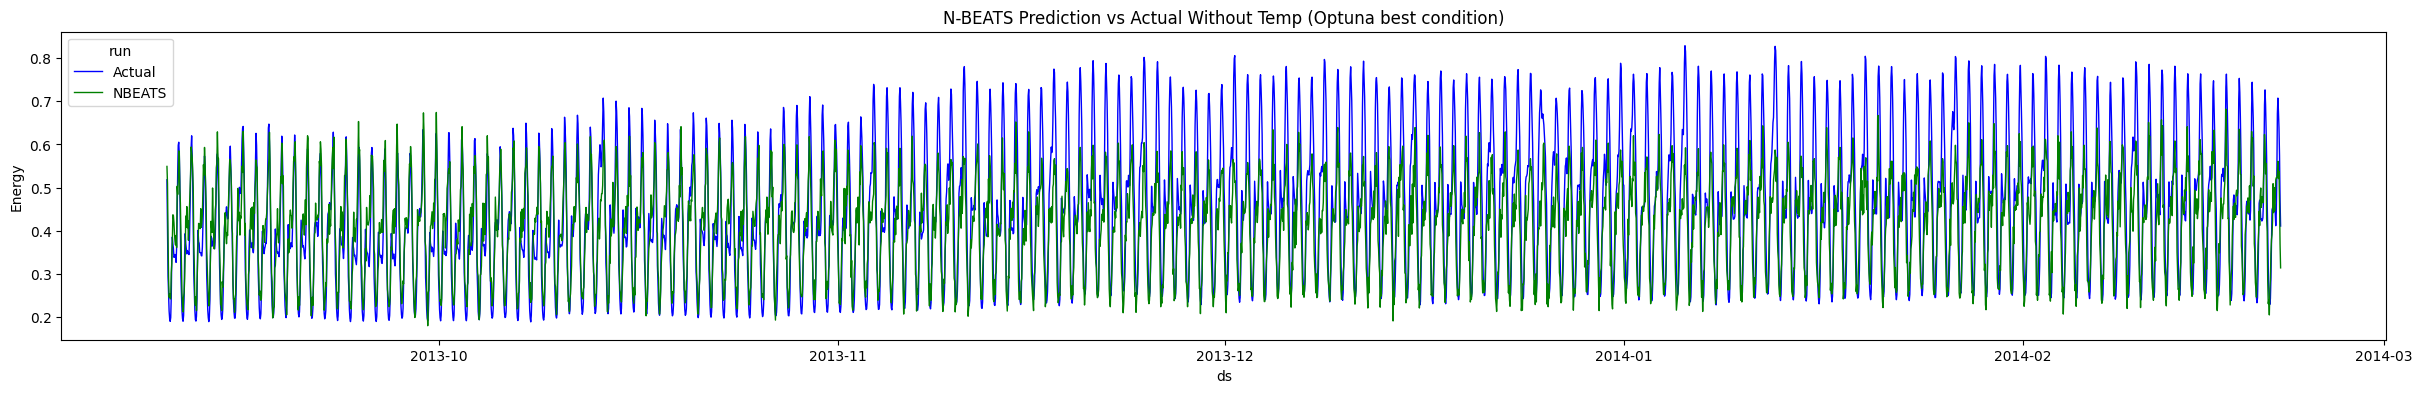

MAE:  0.06927827441386819


In [20]:
df_pred_melt = pd.melt(p, id_vars=['ds'], value_vars=['y', 'NBEATS'], var_name='run', value_name='Energy')
df_pred_melt.replace(to_replace='y', value="Actual", inplace = True)


title = "N-BEATS Prediction vs Actual Without Temp (Optuna best condition)"

plt.figure(figsize=(30,4))
ax = sns.lineplot(data = df_pred_melt, x = 'ds', y = 'Energy', hue = 'run', palette= ['b', 'g'], linewidth = 1)
ax.set_title(title)
plt.show()

print("MAE: ", loss)

In [21]:
# combine prediction results with weather parameters
df_pred_combined = val[['ds','temperature']].merge(p, on = 'ds', how = 'left')
df_pred_combined

,ds,temperature,unique_id,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-hi-90,y
0,2013-09-09 21:00:00,10.33,1,0.549,0.0,0.0,2.0,0.518124
1,2013-09-09 22:00:00,10.33,1,0.509,0.0,0.0,2.0,0.404168
2,2013-09-09 23:00:00,10.33,1,0.385,0.0,0.0,2.0,0.294621
3,2013-09-10 00:00:00,10.33,1,0.290,0.0,0.0,1.0,0.251980
4,2013-09-10 01:00:00,10.36,1,0.246,0.0,0.0,1.0,0.214183
...,...,...,...,...,...,...,...,...
3935,2014-02-20 20:00:00,7.34,1,0.521,0.0,0.0,2.0,0.676087
3936,2014-02-20 21:00:00,6.84,1,0.538,0.0,0.0,2.0,0.638370
3937,2014-02-20 22:00:00,6.86,1,0.468,0.0,0.0,2.0,0.574031
3938,2014-02-20 23:00:00,6.34,1,0.369,0.0,0.0,2.0,0.470768


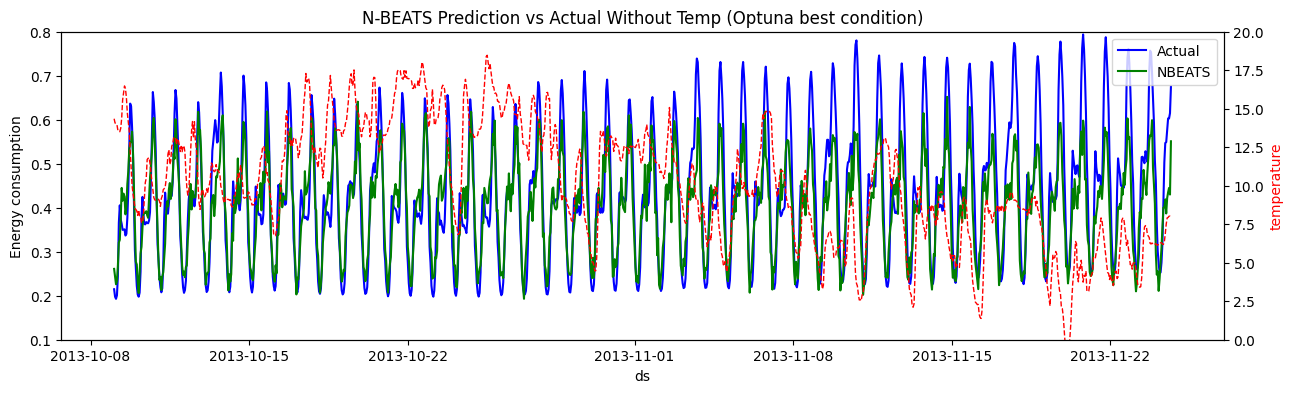

In [22]:
df_pred_nov = df_pred_combined[-3240:-2120].copy()

plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'y', color = 'b', label = 'Actual')
ax.set(ylabel='Energy consumption')
ax2 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'NBEATS', color = 'g', label = 'NBEATS')
ax3 = plt.twinx()
ax3 = sns.lineplot(data = df_pred_nov, x = 'ds', y = 'temperature', color="r", linewidth=1, linestyle='dashed')
ax3.yaxis.label.set_color('r')
ax.set_title(title)
ax.set_ylim(0.1, 0.8)
ax3.set_ylim(0, 20)
ax.legend(loc='upper right')
plt.show()

### Comment: Optuna tuning without or witout temperature as input parameter has not improved the model. The phenomenon observed at winter period remains.